# 14. Preprocessing using Deep Learning
how deep learning can be used in data preprocessing for time series analysis:

Let's consider a scenario where you have a time series dataset that contains temperature measurements recorded every hour over a period of several years. The dataset may have missing values, outliers, and varying scales. You want to preprocess the data before using it for time series analysis.

1. **Handling missing values**: One common approach is to use deep learning models, such as recurrent neural networks (RNNs), to impute missing values in the time series. You can train an RNN on the available data and use it to predict the missing values based on the pattern in the surrounding data points.

2. **Outlier detection**: Deep learning models, such as autoencoders, can be used to detect outliers in the time series data. An autoencoder is trained to reconstruct the input data, and data points that have a high reconstruction error can be considered outliers. By identifying and removing or handling outliers, you can ensure that they don't negatively impact the analysis.

3. **Scaling and normalization**: Deep learning models often benefit from input data that is scaled or normalized. For time series data, you can use techniques like min-max scaling or z-score normalization to bring the values to a consistent range. This helps the model converge faster during training and makes the model more robust to variations in the data.

4. **Handling seasonality and trends**: Deep learning models can also be used to extract seasonality and trends from time series data. For example, you can use a convolutional neural network (CNN) to learn the patterns in the data over different time intervals. This can help in identifying and removing the underlying seasonal or trend components, making the data more stationary and suitable for analysis.

By applying these deep learning techniques in data preprocessing, you can address various challenges associated with time series data, such as missing values, outliers, and varying scales. This sets the foundation for accurate and effective time series analysis and prediction using deep learning models.

## 14.1 Handling missing values using an RNN

In this simple example:

1. We first create a time series data based on a sine wave.
2. We then introduce some missing values in the data.
3. We then prepare sequences of a given timestep (here 5) to use as inputs and the next value as output. We skip sequences with NaN values.
4. We define an RNN model and train it on the sequences.
5. We then use the model to predict the missing values in the data.





In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt


# Create some simple data
data = np.array([i + np.sin(i/5) for i in range(100)])
original_data = data.copy()

# Introduce some missing values
missing_indices = [10, 15, 30, 45, 60]
for idx in missing_indices:
    data[idx] = None

data_with_missing = data.copy()

# Prepare data for RNN
def prepare_data(data, timestep=5):
    X, y = [], []
    for i in range(len(data)-timestep):
        seq = data[i:i+timestep]
        if not np.isnan(seq).any() and not np.isnan(data[i+timestep]):
            X.append(seq)
            y.append(data[i+timestep])
    return np.array(X), np.array(y)

X, y = prepare_data(data)

# Reshape to [samples, timesteps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Define the RNN model
model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=200, verbose=1)

# Predict the missing values
for idx in missing_indices:
    seq = data[idx-5:idx].reshape(1, 5, 1)
    prediction = model.predict(seq)
    data[idx] = prediction[0, 0]



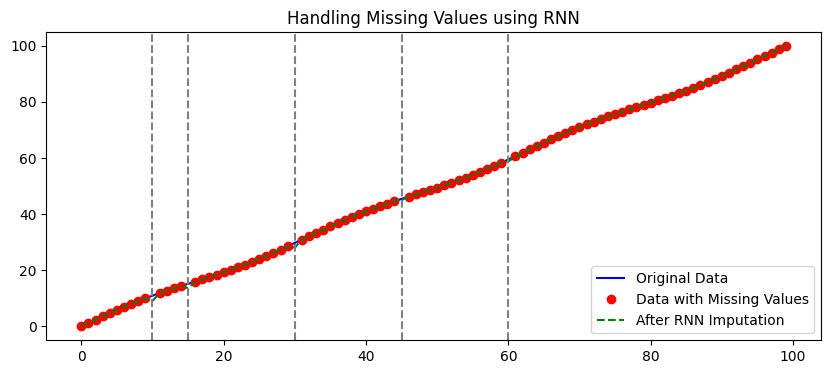

In [ ]:
# Visualization
plt.figure(figsize=(10, 4))

plt.plot(original_data, label="Original Data", color='blue')
plt.plot(data_with_missing, 'o', label="Data with Missing Values", color='red')
plt.plot(data, '--', label="After RNN Imputation", color='green')

for idx in missing_indices:
    plt.axvline(x=idx, color='gray', linestyle='--')

plt.legend()
plt.title("Handling Missing Values using RNN")
plt.show()

## 14.2 Outlier detection using an autoencoder

Autoencoders can be used for outlier detection because they are trained to reconstruct their input data. If an input data point is an outlier, the autoencoder will typically have a higher reconstruction error for that point than for "normal" points. We can thus use the reconstruction error as a measure to detect outliers.

In the below example we will foloow steps:


1. **Data Creation**: I'll use the `make_blobs` function from `sklearn.datasets` to create some clustered data and add a few outliers.
2. **Autoencoder Design**: I'll create a simple autoencoder using TensorFlow and Keras.
3. **Training**: I'll train the autoencoder on the data.
4. **Outlier Detection**: I'll use the reconstruction error to determine outliers.
5. **Visualization**: Finally, I'll visualize the data, highlighting outliers.






In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model

# 1. Data Creation
data, _ = make_blobs(n_samples=300, centers=3, random_state=42)
# Add some outliers
outliers = np.array([[10, -10], [10, 10], [-10, -10], [-10, 10]])
all_data = np.vstack([data, outliers])

# 2. Autoencoder Design
input_layer = Input(shape=(2,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(2, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# 3. Training
autoencoder.fit(all_data, all_data, epochs=100, batch_size=16, shuffle=True, verbose=0)

# 4. Outlier Detection
decoded_data = autoencoder.predict(all_data)
reconstruction_error = np.mean(np.power(all_data - decoded_data, 2), axis=1)

threshold = np.percentile(reconstruction_error, 95)  # Here, 95% quantile is used. Adjust as needed.
outliers_idx = np.where(reconstruction_error > threshold)[0]



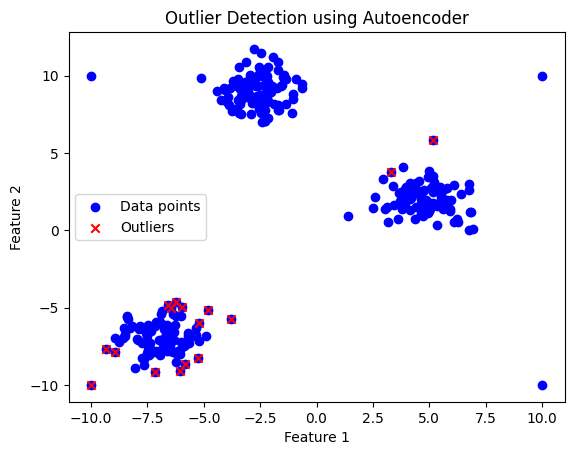

In [ ]:
# 5. Visualization
plt.scatter(all_data[:, 0], all_data[:, 1], c='b', label='Data points')
plt.scatter(all_data[outliers_idx, 0], all_data[outliers_idx, 1], c='r', marker='x', label='Outliers')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Outlier Detection using Autoencoder')
plt.show()
exit()

## 14.3 Handling seasonality and trends using a CNN


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Generate synthetic data with seasonality and trends
np.random.seed(0)
time = np.arange(0, 1000)
trend = 0.05 * time
seasonality = 10 * np.sin(0.02 * time)
noise = 5 * np.random.randn(len(time))
data = trend + seasonality + noise
# Prepare the data for CNN input
window_size = 50
X = []
y = []
for i in range(len(data) - window_size):
    X.append(data[i:i+window_size])
    y.append(data[i+window_size])
X = np.array(X)
y = np.array(y)

# Reshape the data for CNN input
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Create the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model on the testing data
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions on the testing data
predictions = model.predict(X_test)



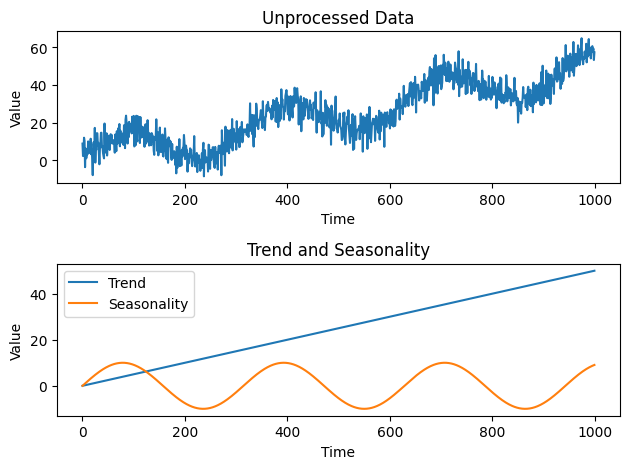

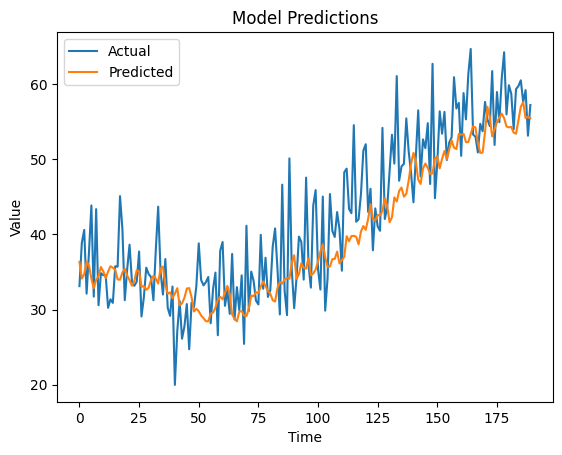

In [ ]:
# Visualize the actual data, trends, seasonality, and predictions
plt.figure()

plt.subplot(2, 1, 1)
plt.plot(time, data)
plt.title('Unprocessed Data')
plt.xlabel('Time')
plt.ylabel('Value')

plt.subplot(2, 1, 2)
plt.plot(time, trend, label='Trend')
plt.plot(time, seasonality, label='Seasonality')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Trend and Seasonality')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Model Predictions')
plt.legend()
plt.show()